In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option("display.precision", 3)
InteractiveShell.ast_node_interactivity = "all"

In [30]:
# Extra imports
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix


from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

In [33]:
# Prepare data function used in other scripts 

def prepare_data(dataframe, variables, num_scaling = True):
    x = dataframe.loc[:, dataframe.columns != 'SUSPECT_RACE_DESCRIPTION']
    y = dataframe.loc[:, 'SUSPECT_RACE_DESCRIPTION']
    X_train, X_test, y_train, y_test =\
        train_test_split(x,y, test_size=0.2, random_state=14, stratify=y)
    X_train = X_train.loc[:,variables]
    X_test = X_test.loc[:,variables]
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)
    numericals = []
    for idx, types in enumerate(X_train.dtypes):
        if types == 'int64':
            numericals.append(X_train.columns[idx])
    
        
        
    return X_train, X_test, y_train, y_test


df = pd.read_csv(os.path.join(data_path,'train_preprocessed_final_noMCA.csv'), index_col=[0])

vars_to_keep =  list(df.columns)
vars_to_keep.remove('SUSPECT_RACE_DESCRIPTION')

df['KMEANS_DEMEANOR'] = df.KMEANS_DEMEANOR.astype('object')


X_train, X_test, y_train, y_test = prepare_data(df, vars_to_keep, num_scaling=True)

# Decision Trees

In [34]:
model_tree = DecisionTreeClassifier().fit(X_train, 
                                          y_train)

X_train.shape, X_test.shape

((6056, 72), (1514, 72))

In [35]:
y_pred = model_tree.predict(X_test)

results.loc['DT-default',:] = compute_metrics(y_test, y_pred)

confusion(y_test, y_pred)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,689,44,255
OTHER,32,8,22
WHITE,206,23,235


In [36]:
compute_metrics(y_test, y_pred)

[0.6155878467635403,
 array([0.71958225, 0.11678832, 0.48155738]),
 0.43930931454929095,
 0.6219489810758707,
 0.444288732119509]

In [37]:
f1_score(y_test, y_pred,average=None)

array([0.71958225, 0.11678832, 0.48155738])

In [38]:
print(classification_report(y_test,
                            y_pred,
                            target_names=['Black', 'Other', 'White'],))

results

              precision    recall  f1-score   support

       Black       0.74      0.70      0.72       988
       Other       0.11      0.13      0.12        62
       White       0.46      0.51      0.48       464

    accuracy                           0.62      1514
   macro avg       0.44      0.44      0.44      1514
weighted avg       0.63      0.62      0.62      1514



,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444


In [39]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 34
Nodes: 3139


In [40]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()



scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'balanced_accuracy'
}


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=14, shuffle = True)

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=cv,
                   return_train_score=False,
                   error_score="raise",
                   refit="f1_mac")

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:03:01.864024


In [41]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac', 'mean_test_acc',
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head()
y_pred = model_5CV.predict(X_test)

results.loc['DT-best-MacroF1',:] = compute_metrics(y_test, y_pred)

confusion(y_test,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
268,gini,15,sqrt,3,2,0.442,0.431
0,gini,None,auto,1,2,0.435,0.436
700,entropy,15,None,1,2,0.434,0.430
415,entropy,None,auto,4,5,0.433,0.423
246,gini,15,auto,2,4,0.433,0.424


predicted,BLACK,OTHER,WHITE
target,,,
BLACK,882,8,98
OTHER,49,3,10
WHITE,317,8,139


,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


In [42]:
f1_score_per_class = f1_score(y_test, y_pred, average=None)
f1_score_per_class

array([0.78890877, 0.07407407, 0.39099859])

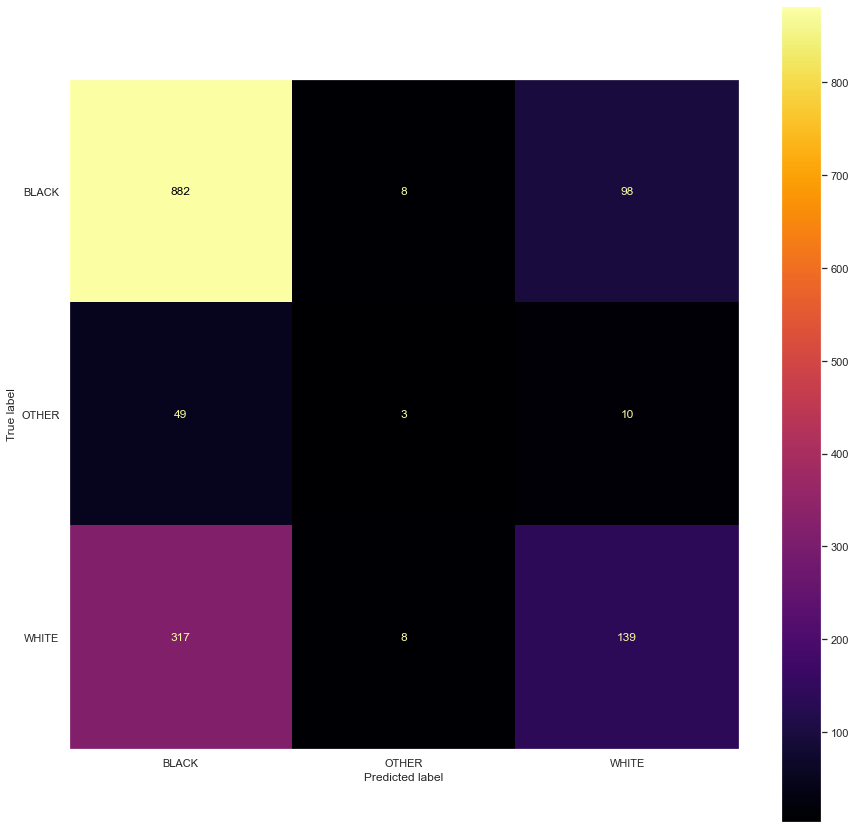

In [43]:
#image
cm = confusion_matrix(y_test, y_pred, labels=model_5CV.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_5CV.classes_)
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(False)
disp.plot(ax=ax, cmap=plt.cm.inferno)

In [44]:
best_params = model_5CV.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [45]:
pred = model_5CV.predict(X_train)

confusion(y_train,pred)

print(classification_report(y_train,
                            pred,
                            target_names=['Black', 'Other', 'White'],))

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,3758,9,183
OTHER,177,31,39
WHITE,1046,13,800


              precision    recall  f1-score   support

       Black       0.75      0.95      0.84      3950
       Other       0.58      0.13      0.21       247
       White       0.78      0.43      0.56      1859

    accuracy                           0.76      6056
   macro avg       0.71      0.50      0.53      6056
weighted avg       0.76      0.76      0.73      6056



In [46]:
print(classification_report(y_test,
                            y_pred,
                            target_names=['Black', 'White', 'Other'],))

              precision    recall  f1-score   support

       Black       0.71      0.89      0.79       988
       White       0.16      0.05      0.07        62
       Other       0.56      0.30      0.39       464

    accuracy                           0.68      1514
   macro avg       0.48      0.41      0.42      1514
weighted avg       0.64      0.68      0.64      1514



# Random Forests

In [47]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(y_train,pred)

print(classification_report(y_train,
                            pred,
                            target_names=['Black', 'Other', 'White'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,3950,0,0
OTHER,0,247,0
WHITE,1,0,1858


              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      3950
       Other       1.00      1.00      1.00       247
       White       1.00      1.00      1.00      1859

    accuracy                           1.00      6056
   macro avg       1.00      1.00      1.00      6056
weighted avg       1.00      1.00      1.00      6056

OOB accuracy= 0.7161492734478203


In [48]:
y_pred = model_rf1.predict(X_test)
print('Validation Accuracy:{}'.format(model_rf1.score(X_test,y_test)))
results.loc['RF-default',:] = compute_metrics(y_test,y_pred)
confusion(y_test,y_pred)

Validation Accuracy:0.73778071334214


predicted,BLACK,OTHER,WHITE
target,,,
BLACK,923,1,64
OTHER,43,3,16
WHITE,272,1,191


In [49]:
f1_score_per_class = f1_score(y_test, y_pred, average=None)
f1_score_per_class

array([0.82929021, 0.08955224, 0.51972789])

In [50]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
RF-default,0.738,"[0.8292902066486972, 0.08955223880597016, 0.51...",0.48,0.704,0.465
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


In [51]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(y_test, pred)

print(classification_report(y_train,pred,target_names=['Black', 'Other', 'White'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,663,30,295
OTHER,44,1,17
WHITE,310,30,124


              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      3950
       Other       1.00      1.00      1.00       247
       White       1.00      1.00      1.00      1859

    accuracy                           1.00      6056
   macro avg       1.00      1.00      1.00      6056
weighted avg       1.00      1.00      1.00      6056

OOB accuracy= 0.7131770145310435


In [52]:
y_pred = model_rf2.predict(X_test)

results.loc['RF-balance',:] = compute_metrics(y_test,y_pred)

confusion(y_test,y_pred)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,925,1,62
OTHER,45,3,14
WHITE,283,1,180


In [53]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
RF-default,0.738,"[0.8292902066486972, 0.08955223880597016, 0.51...",0.48,0.704,0.465
RF-balance,0.732,"[0.8255243195002231, 0.08955223880597016, 0.5]",0.472,0.696,0.458
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


In [91]:

init_time = time()
from sklearn.model_selection import RepeatedStratifiedKFold

rf_model = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [200,400,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,40]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
balance = [None, 'balanced', 'balanced_subsample']


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14)

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance,
                       'bootstrap': bootstrap

                   },
                   cv=cv,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1, verbose=10)

best_rf = model_5CV = trc.fit(X_train, y_train)


print(timedelta(seconds=(time() - init_time)))

Fitting 2 folds for each of 486 candidates, totalling 972 fits
0:23:34.277354


In [92]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_class_weight', 'param_bootstrap'
    ,'mean_test_f1_mac'] 
pd.DataFrame(best_rf.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_class_weight,param_bootstrap,mean_test_f1_mac
423,200,20,4,2,balanced_subsample,False,0.502
340,400,20,2,10,balanced,False,0.500
481,400,None,4,5,balanced_subsample,False,0.499
424,400,20,4,2,balanced_subsample,False,0.498
369,200,40,4,2,balanced,False,0.498


In [93]:
best_params = pd.DataFrame(best_rf.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [94]:
best_rf_tuned = RandomForestClassifier(**best_params)
best_rf_tuned.fit(X_train, y_train)

y_pred = best_rf_tuned.predict(X_test)

results.loc['RF-best', :] = compute_metrics(y_test, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=20, min_samples_leaf=4, n_estimators=200)

,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
RF-best,0.696,"[0.7875185735512631, 0.18518518518518517, 0.55...",0.508,0.69,0.5
extra_trees-best,0.701,"[0.7951807228915663, 0.18947368421052632, 0.52...",0.505,0.689,0.49
RF-default,0.738,"[0.8292902066486972, 0.08955223880597016, 0.51...",0.48,0.704,0.465
extra_trees,0.715,"[0.8111111111111112, 0.1111111111111111, 0.510...",0.477,0.69,0.463
RF-balance,0.732,"[0.8255243195002231, 0.08955223880597016, 0.5]",0.472,0.696,0.458
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


In [95]:
confusion(y_test, y_pred)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,795,26,167
OTHER,30,10,22
WHITE,206,10,248


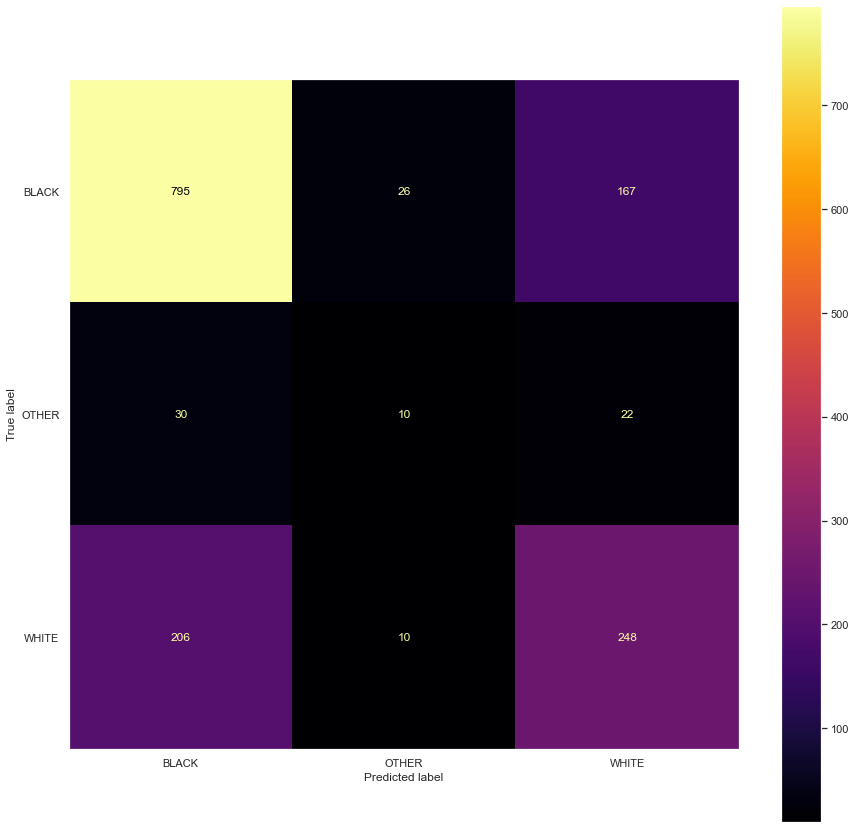

In [96]:
#image
cm = confusion_matrix(y_test, y_pred, labels=best_rf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_tuned.classes_)
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(False)
disp.plot(ax=ax, cmap=plt.cm.inferno)

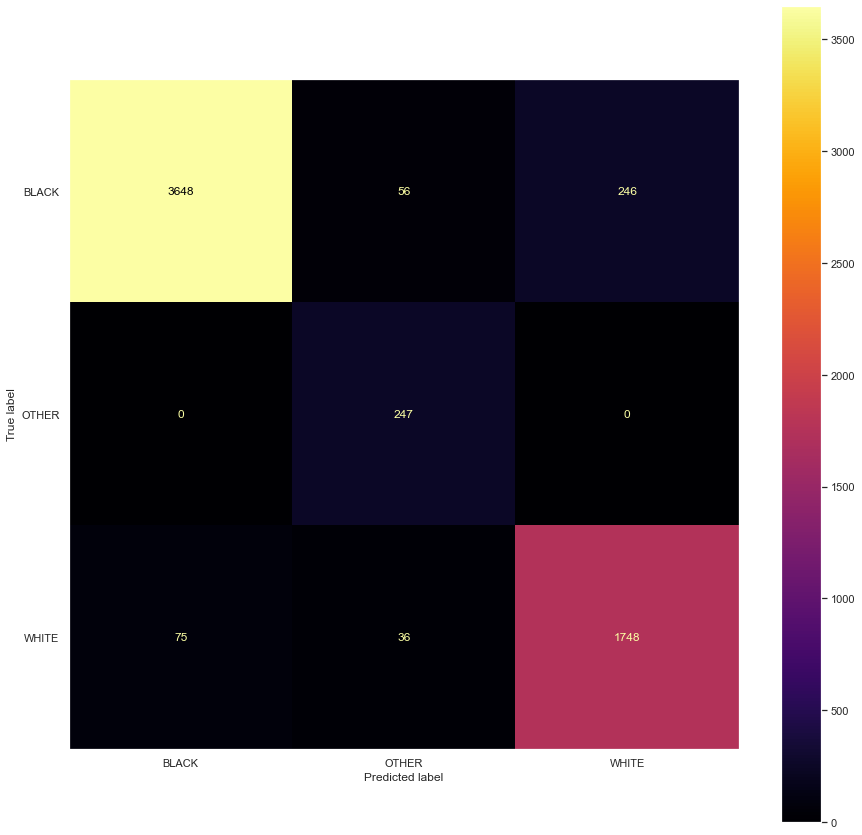

In [98]:
#confusion matrix train set
y_pred = best_rf_tuned.predict(X_train)

cm = confusion_matrix(y_train, y_pred, labels=best_rf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_tuned.classes_)
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(False)
disp.plot(ax=ax, cmap=plt.cm.inferno)

# Extra Trees

In [99]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_test)

results.loc['extra_trees',:] = compute_metrics(y_test,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

ExtraTreesClassifier()

,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
RF-best,0.696,"[0.7875185735512631, 0.18518518518518517, 0.55...",0.508,0.69,0.5
extra_trees-best,0.701,"[0.7951807228915663, 0.18947368421052632, 0.52...",0.505,0.689,0.49
extra_trees,0.718,"[0.8123559243891194, 0.15999999999999998, 0.51...",0.494,0.693,0.473
RF-default,0.738,"[0.8292902066486972, 0.08955223880597016, 0.51...",0.48,0.704,0.465
RF-balance,0.732,"[0.8255243195002231, 0.08955223880597016, 0.5]",0.472,0.696,0.458
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


In [104]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

n_estimators = [200,400,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,40]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
balance = [None, 'balanced', 'balanced_subsample']

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)


trc = GridSearchCV(estimator=best_rf_tuned,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance,
                       'bootstrap': bootstrap
                   },
                   cv=cv,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1, verbose=3)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
0:09:42.551396


In [105]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_class_weight', 
     'mean_test_f1_mac', 'param_bootstrap'] 

In [106]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_class_weight,mean_test_f1_mac,param_bootstrap
298,150,40,2,10,balanced_subsample,0.530,False
120,150,20,4,2,balanced_subsample,0.528,True
304,150,40,4,10,balanced_subsample,0.527,False
256,150,None,1,10,balanced,0.527,False
106,150,None,4,10,balanced,0.526,True


In [107]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'max_depth': 40,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 150}

In [108]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_test)

results.loc['extra_trees-best',:] = compute_metrics(y_test,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

ExtraTreesClassifier(class_weight='balanced_subsample', max_depth=40,
                     min_samples_leaf=2, min_samples_split=10,
                     n_estimators=150)

,Accuracy,F1-score class,F1-score (macro avg),F1-score (weighted avg),Balanced Accuracy
RF-best,0.696,"[0.7875185735512631, 0.18518518518518517, 0.55...",0.508,0.69,0.5
extra_trees-best,0.672,"[0.7709384460141271, 0.1904761904761905, 0.533...",0.498,0.675,0.505
extra_trees,0.718,"[0.8123559243891194, 0.15999999999999998, 0.51...",0.494,0.693,0.473
RF-default,0.738,"[0.8292902066486972, 0.08955223880597016, 0.51...",0.48,0.704,0.465
RF-balance,0.732,"[0.8255243195002231, 0.08955223880597016, 0.5]",0.472,0.696,0.458
DT-default,0.616,"[0.7195822454308094, 0.11678832116788321, 0.48...",0.439,0.622,0.444
DT-best-MacroF1,0.676,"[0.7889087656529516, 0.07407407407407407, 0.39...",0.418,0.638,0.414


4) Feature Importance

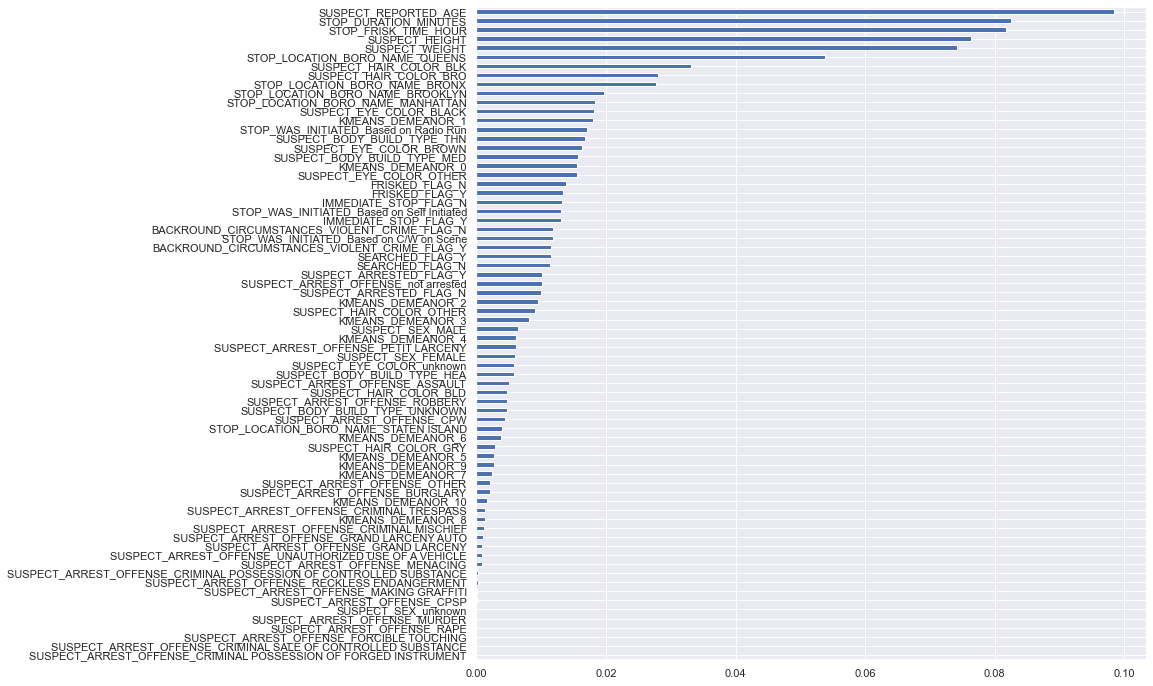

In [102]:
var_imp = pd.DataFrame({'importance': best_rf_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(12,12),
                                               legend=False);

In [100]:
# SAVING BEST MODEL
import _pickle as cPickle


with open(os.path.join(model_path,'final_rd.model'), 'wb') as f:
    cPickle.dump(best_rf_tuned, f)

with open(os.path.join(model_path,'final_rd.model'), 'rb') as f:
    rf = cPickle.load(f)

y_pred = rf.predict(X_test)
confusion(y_test, y_pred)

predicted,BLACK,OTHER,WHITE
target,,,
BLACK,795,26,167
OTHER,30,10,22
WHITE,206,10,248
